In [14]:
%load_ext autoreload
%autoreload 2
from matplotlib.path import Path
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import argparse
import os, sys
sys.path.append(os.path.dirname(os.getcwd()))
import polygon_primitives.file_writer as fw

from image_processing import extract_window_wall_ratio, utils, contour_extraction
from scipy.spatial import Delaunay

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


First, we set the image and parameter directories, as well as the merged polygons file path. We load the merged polygons, as wWe also initialize a dictionary for the Cameras. The Camera class stores all information related to the camera, i.e. intrinsic and extrinsic camera parameters.

In [19]:
#Example file
filename = "DJI_0081.JPG"

directory = "../data/Drone_Flight/"
facade_file = "../data/Drone_Flight/merged.txt"

image_dir = directory + "RGB/"
param_dir = directory + "params/"
predictions_dir = directory + "predictions/"

offset = np.loadtxt(param_dir + "offset.txt",usecols=range(3))

#Initializes a dictionary of Camera classes. See utils.py for more information.
camera_dict = utils.create_camera_dict(param_dir, offset=offset)

#Loads pmatrices and image filenamees
p_matrices = np.loadtxt(param_dir + 'pmatrix.txt', usecols=range(1,13))

#Loads the merged polygons, as well as a list of facade types (i.e. roof, wall, or floor)
merged_polygons, facade_type_list, file_format = fw.load_merged_polygon_facades(filename=facade_file)

#Offset adjustment parameter
height_adj = np.array([0.0, 0.0, 108])
offset = offset + height_adj


Next, we extract the contours for the window predictions, by taking the window prediction points and using them to create a shapely polygon.

Window predictions: 


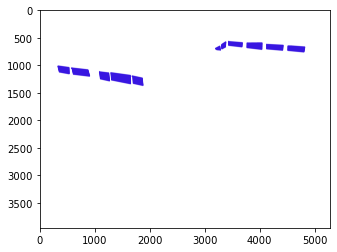

Extracted contours: 


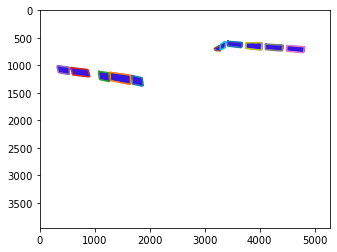

In [18]:
window_file = predictions_dir + "DJI_0081_Windows.png"

print("Window predictions: ")
image = cv2.imread(window_file)
plt.imshow(image)
plt.show()

#Extract the contours of the window file
contours = contour_extraction.extract_contours(window_file)

#Create polygons from the window contours
window_polygons = utils.convert_polygons_shapely(contours)


def plot_shapely_polys(image_file, polys):
    for poly in polys:
        s = poly
        s = poly.simplify(0.1, preserve_topology=True)
        x,y = s.exterior.xy
        plt.plot(x,y)
    plt.show()

print("Extracted contours: ")
plt.imshow(image)
plot_shapely_polys(window_file, window_polygons)

Finally, for each window point, we obtain its 3D coordinates and use them to calculate the window to wall ratio.

In [30]:
camera = camera_dict[filename]
pmatrix = camera.calc_pmatrix()

image_file = utils.load_image(image_dir + filename)

#Projects the merged polygon facades onto the camera image
projected_facades, projective_distances = extract_window_wall_ratio.project_merged_polygons(
    merged_polygons, offset, pmatrix)

#Creates a dictionary mapping the facade to the windows contained within them, keyed by facade index
facade_window_map = extract_window_wall_ratio.get_facade_window_map(
    window_polygons, projected_facades, projective_distances)

#Creates a list of all the facades in the merged polygon
facades = []
for poly in merged_polygons:
    facades = facades + poly

facade_indices = list(facade_window_map.keys())
for i in facade_indices:
    #Computes window to wall ratio
    win_wall_ratio = extract_window_wall_ratio.get_window_wall_ratio(
        projected_facades[i], facades[i], facade_window_map[i])

    #Output printing:
    print("Facade index: " + str(i))
    print("Window-to-wall ratio: " + str(win_wall_ratio))
    
    #Uncomment this line to plot the windows and facades on the image
#     extract_window_wall_ratio.plot_windows_facade(projected_facades[i], facade_window_map[i], image_file)

Facade index: 22
Window-to-wall ratio: 0.0977586847480746
Facade index: 25
Window-to-wall ratio: 0.07369005447146922
Facade index: 12
Window-to-wall ratio: 0.11308840228711164
